In [ ]:
!git clone https://github.com/Vinit-source/SNInfluenceMaximization.git

Cloning into 'SNInfluenceMaximization'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 25 (delta 3), reused 0 (delta 0), pack-reused 15
Unpacking objects: 100% (25/25), done.


# Install Ray

In [ ]:
# # Install Ray for parallelism
# print('NOTE: Intentionally crashing session to use the newly installed library.\n')

# !pip uninstall -y pyarrow
# !pip install ray[default]
# !pip install bs4

# try:
#   import ray
# except:
#   # A hack to force the runtime to restart, needed to include the above dependencies.
#   import os
#   os._exit(0)

# Imports

In [ ]:
# Imports
import networkx as nx
import numpy as np
import random
import os
import pandas as pd
import time
import matplotlib.pyplot as plt
%matplotlib inline
import psutil

# Constants
CURR_DIR = "/content"

# Utils

In [ ]:
def plot(G, pos=None, seed=20532, label_options=None):
    if pos == None:
        pos = nx.spring_layout(G, seed=seed)
    if label_options == None:
        label_options = {"ec": "k", "fc": "white", "alpha": 0.7}
    if len(G) < 100:
        fs = 14
    else:
        fs = 10
    nx.draw(G, pos)
    nx.draw_networkx_labels(G, pos, font_size=fs, bbox=label_options)
    plt.show()

def create_dist_for_graph_edges(graph):
    probs = [random.random() for _ in range(len(graph.edges))]
    for edge, p in zip(graph.edges, probs):
        graph.edges[edge]['prob'] = p
    return graph

def create_normalized_weights_for_graph_edges(graph):
    graph = create_dist_for_graph_edges(graph)
    graph = nx.DiGraph(graph)
    for node in graph.nodes:
        for edge in graph.in_edges(node):
            graph.edges[edge]['weight'] = graph.edges[edge]['prob'] / graph.in_degree(node)
    return graph


# Classes: Independent Cascade, Linear Threshold

In [ ]:
import numpy as np
import networkx as nx
from tqdm import tqdm
from time import gmtime, strftime
# import ray

# @ray.remote
class IndependentCascade(object):
    def __init__(self, graph, prob):
        self.graph = graph
        dir = f"{CURR_DIR}/temp/IC"
        os.makedirs(dir) if not os.path.exists(dir) else None
        now = strftime("%Y_%m_%d_%H_%M_%S", gmtime())
        self.prob_matrix_filepath = f"{dir}/prob_{now}.npy"
        self.sampled_graph = graph.copy()
        self.reverse_edge_idx = {i: e for i, e in enumerate(self.graph.edges())}
        self.prob = prob
    
    def sample_live_graph_mc(self, mc):
        no_of_edges = len(self.graph.edges)
        np.save(self.prob_matrix_filepath, np.array([]))
        prob_matrix = np.memmap(self.prob_matrix_filepath, dtype='float32', mode='r+', shape=(mc, no_of_edges))
        print("Sampling graphs for Monte Carlo Simulations...") if not self.quiet else None
        for i in range(mc):
            prob_matrix[i, :] = np.random.uniform(size=no_of_edges)
            prob_matrix.flush()
        self.sampled_graphs = []
        for p in prob_matrix:
            p = np.array(p)
            self.sampled_graphs.append(np.array([p < self.prob]).astype(np.int8))
  
    def sample_live_graph(self, mcount):
        removed_edges_idx = np.where(self.sampled_graphs[mcount] == 0)[1].tolist()
        removed_edges = [self.reverse_edge_idx[i] for i in removed_edges_idx]
        Gp = self.graph.copy()
        Gp.remove_edges_from(removed_edges)
        self.sampled_graph = Gp

    def diffusion_iter(self, act_nodes):
        new_act_nodes = set(act_nodes)
        for node in act_nodes:
            for node2 in nx.algorithms.bfs_tree(self.sampled_graph, node).nodes():
                new_act_nodes.add(node2)
        for node in new_act_nodes:
            self.sampled_graph.nodes[node]['is_active'] = True

    def diffuse(self, act_nodes, mcount):
        self.sample_live_graph(mcount)
        nx.set_node_attributes(self.sampled_graph, False, name='is_active')

        for node in act_nodes:
            self.sampled_graph.nodes[node]['is_active'] = True
        
        self.diffusion_iter(act_nodes)
        active_nodes = [n for n, v in self.sampled_graph.nodes.data() if v['is_active']]
        self.graph.total_activated_nodes.append(len(active_nodes))

    def diffuse_mc(self, act_nodes, mc=10, quiet=False):
        self.quiet = quiet
        self.sample_live_graph_mc(mc)
        self.graph.total_activated_nodes = []
        print("Running Monte Carlo simulations...") if not self.quiet else None
        for mcount in range(mc):
            # print("=>", psutil.virtual_memory()[2], "% of memory used.")
            self.diffuse(act_nodes, mcount)
        total_act_nodes = pd.Series(self.graph.total_activated_nodes)
        return total_act_nodes.mean(), total_act_nodes.std()

class LinearThreshold(object):
    def __init__(self, graph):
        self.graph = graph
        self.neighborhood_fn = self.graph.neighbors if isinstance(self.graph, nx.Graph) else self.graph.predecessors
        dir = f"{CURR_DIR}/temp/LT"
        os.makedirs(dir) if not os.path.exists(dir) else None
        now = strftime("%Y_%m_%d_%H_%M_%S", gmtime())
        self.sampled_thresholds_filepath = f"{dir}/prob_{now}.npy"

    def sample_node_thresholds_mc(self, mc):
        no_of_nodes = len(self.graph.nodes)
        np.save(self.sampled_thresholds_filepath, np.array([]))
        self.sampled_thresholds = np.memmap(self.sampled_thresholds_filepath, dtype='float32', mode='r+', shape=(mc, no_of_nodes))
        print("Sampling Thresholds for Monte Carlo Simulations...") if not self.quiet else None
        for i in range(mc):
            self.sampled_thresholds[i, :] = np.random.uniform(size=no_of_nodes)
            self.sampled_thresholds.flush()
        self.sampled_thresholds = np.random.uniform(size=(mc, len(self.graph.nodes)))

    def sample_node_thresholds(self, mcount):
        row = np.array(self.sampled_thresholds[mcount])
        for idx, node in enumerate(self.graph.nodes):
            self.graph.nodes[node]['threshold'] = row[idx]

    def diffusion_iter(self):
        for node in self.graph.nodes:
            if self.graph.nodes[node]['is_active']:
                continue
            neighbors = self.neighborhood_fn(node)
            weights = sum(self.graph.edges[neighbor, node]['weight'] for neighbor in neighbors)
            if weights > self.graph.nodes[node]['threshold']:
                self.graph.nodes[node]['is_active'] = True

    def diffuse(self, act_nodes, mcount):
        self.sample_node_thresholds(mcount)
        nx.set_node_attributes(self.graph, False, name='is_active')

        for node in act_nodes:
            self.graph.nodes[node]['is_active'] = True

        prev_active_nodes = set()
        active_nodes = set()
        while True:
            self.diffusion_iter()
            prev_active_nodes = active_nodes
            active_nodes = set(i for i, v in self.graph.nodes(data=True) if v['is_active'])
            if active_nodes == prev_active_nodes:
                break
        self.graph.total_activated_nodes.append(len(active_nodes))

    def diffuse_mc(self, act_nodes, mc=10, quiet=False):
        self.quiet = quiet
        self.sample_node_thresholds_mc(mc)
        self.graph.total_activated_nodes = []
        print("Running Monte Carlo simulations...") if not self.quiet else None
        for mcount in range(mc):
            self.diffuse(act_nodes, mcount)
        total_act_nodes = pd.Series(self.graph.total_activated_nodes)
        return total_act_nodes.mean(), total_act_nodes.std()


# Create Graph

In [ ]:
# Create BA graph
G = nx.barabasi_albert_graph(1000, 5)
G = create_normalized_weights_for_graph_edges(G)

print("Barabasi-Albert", nx.info(G))
s = nx.info(G)[:-6]
# if not s[-5].isnumeric():
#     plot(G)

Barabasi-Albert DiGraph with 1000 nodes and 9950 edges


# Run simulations

## Independent Cascade

Active Set(1): [281]
Sampling graphs for Monte Carlo Simulations...
Running Monte Carlo simulations...
Number of nodes influenced (Mean+/-Std-dev.): 5.03+/-13.154015665496605
Active Set(5): [142, 228, 250, 281, 754]
Sampling graphs for Monte Carlo Simulations...
Running Monte Carlo simulations...
Number of nodes influenced (Mean+/-Std-dev.): 22.467+/-24.133572887998543
Active Set(10): [104, 142, 228, 250, 281, 558, 692, 754, 758, 913]
Sampling graphs for Monte Carlo Simulations...
Running Monte Carlo simulations...
Number of nodes influenced (Mean+/-Std-dev.): 38.109+/-27.253364285255927
Active Set(15): [30, 32, 89, 104, 142, 228, 250, 281, 432, 558, 604, 692, 754, 758, 913]
Sampling graphs for Monte Carlo Simulations...
Running Monte Carlo simulations...
Number of nodes influenced (Mean+/-Std-dev.): 63.855+/-30.20427574488873
Active Set(20): [30, 32, 89, 95, 104, 142, 223, 228, 238, 250, 281, 432, 517, 558, 604, 616, 692, 754, 758, 913]
Sampling graphs for Monte Carlo Simulations...
R

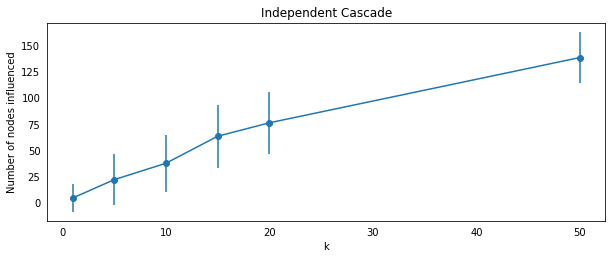

In [ ]:
# Prob for IC model
p = random.uniform(0.05, 0.15)
# loop over different sizes of seed set
act_nodes = []
means = []
stds = []
seed_exps = [1, 5, 10, 15, 20, 50]
for k in seed_exps:
    sampled_nodes = random.sample(G.nodes, k-len(act_nodes))
    act_nodes += sampled_nodes
    # run ic algo
    ic = IndependentCascade(G, p)
    print(f"Active Set({k}):", sorted(act_nodes))
    mean, std = ic.diffuse_mc(act_nodes, mc=1000)
    print(f"Number of nodes influenced (Mean+/-Std-dev.): {mean}+/-{std}")
    # collect results
    means.append(mean); stds.append(std)

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(211)
ax.errorbar(seed_exps, means, yerr=stds, label="Indpendent Cascade",fmt='-o')
plt.ylabel('Number of nodes influenced')
plt.xlabel('k')
plt.title('Independent Cascade')
plt.tick_params(bottom = False, left = False)
plt.show()

## How to simulate over large graphs?

### Memory Profiler

In [ ]:
!pip install -q memory_profiler
# !python script.py
from memory_profiler import memory_usage
import numpy as np
mem_usage, out = memory_usage((np.random.uniform, [], {'size' : (10000, 21000)}), interval=1, timeout=None, max_iterations=1, include_children=True, retval=True)
print(mem_usage)    # Memory usage in MiB
print(out.shape)

[127.86328125, 228.4140625, 908.29296875, 1590.29296875, 1832.3046875]
(10000, 21000)


In [ ]:
# from memory_profiler import memory_usage
# import numpy as np
# # Session crashed
# mem_usage, out = memory_usage((np.random.uniform, [], {'size' : (10000, 210000)}), interval=1, timeout=None, max_iterations=1, include_children=True, retval=True)
# print(mem_usage)
# print(out.shape)

**Problem 1:** Storing initial table of probabilities for large number of Monte Carlo simulations and large graphs overflows RAM.

### Np.memmap

In [ ]:
import numpy as np
b=np.array([1, 2])
filename = '123.npy'
np.save(filename, np.array([]))
X = np.memmap(filename, dtype='float32', mode='r+', shape=(10000,210000))
for i in range(10):
    X[i, :] = np.random.uniform(size=(210000))
    X.flush()

In [ ]:
# newfp = np.memmap(filename, dtype='float32', mode='r+', shape=(10000, 210000))
d = np.array(X[0])
d

array([0.46999818, 0.08952226, 0.21862078, ..., 0.8881003 , 0.443403  ,
       0.31242326], dtype=float32)

Numpy Memmaps can be used to sequentially load or store table from disk to memory so that the whole table need not be loaded into the memory. This technique solved Problem 1. 

**Problem 2:** Running large number of Monte-Carlo simulations over large graphs takes longer times.

I tried solving this problem using multiprocessing libraries like Ray. However, disintegration of code is required and some knowledge of parallel programming. I, therefore, compromised with mc=1000 instead of mc=10000.

## Linear Threshold

Active Set(1): [367]
Sampling Thresholds for Monte Carlo Simulations...
Running Monte Carlo simulations...
Number of nodes influenced (Mean+/-Std-dev.): 497.356+/-14.981244998387249
Active Set(5): [270, 352, 367, 618, 867]
Sampling Thresholds for Monte Carlo Simulations...
Running Monte Carlo simulations...
Number of nodes influenced (Mean+/-Std-dev.): 499.498+/-14.786231048804447
Active Set(10): [44, 270, 352, 367, 470, 549, 618, 747, 826, 867]
Sampling Thresholds for Monte Carlo Simulations...
Running Monte Carlo simulations...
Number of nodes influenced (Mean+/-Std-dev.): 501.171+/-15.047397887448273
Active Set(15): [44, 80, 127, 270, 352, 367, 387, 470, 549, 618, 747, 826, 867, 944, 996]
Sampling Thresholds for Monte Carlo Simulations...
Running Monte Carlo simulations...
Number of nodes influenced (Mean+/-Std-dev.): 504.149+/-15.666149087354812
Active Set(20): [44, 80, 127, 270, 300, 352, 367, 387, 470, 549, 565, 618, 633, 643, 747, 826, 849, 867, 944, 996]
Sampling Thresholds for

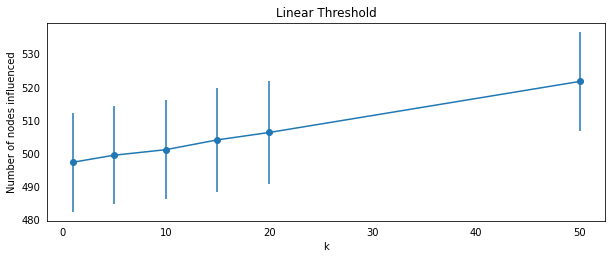

In [ ]:
# loop over different sizes of seed set
act_nodes = []
means = []
stds = []
seed_exps = [1, 5, 10, 15, 20, 50]
for k in seed_exps:
    sampled_nodes = random.sample(G.nodes, k-len(act_nodes))
    act_nodes += sampled_nodes
    # run lt algo
    lt = LinearThreshold(G)
    print(f"Active Set({k}):", sorted(act_nodes))
    mean, std = lt.diffuse_mc(act_nodes, mc=1000)
    print(f"Number of nodes influenced (Mean+/-Std-dev.): {mean}+/-{std}")
    # collect results
    means.append(mean); stds.append(std)

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(211)
ax.errorbar(seed_exps, means, yerr=stds, label="Linear Threshold",fmt='-o')
plt.ylabel('Number of nodes influenced')
plt.xlabel('k')
plt.title('Linear Threshold')
plt.tick_params(bottom = False, left = False)
plt.show()

# Greedy Algorithm

## Simple Greedy Algorithm

In [ ]:
def greedy(graph, diffuse, k):
    S = set()
    A = set(graph.nodes)
    while len(S) < k:
        node_diffusion = {}
        print("Current size of S:", len(S))
        print("Running Diffusion")
        for node in tqdm(A):
            S.add(node)
            node_diffusion[node] = diffuse.diffuse_mc(S, quiet=True)
            S.remove(node)
        max_node = max(node_diffusion.items(), key=lambda x: x[1])[0]
        S.add(max_node)
        A.remove(max_node)
    return S   

## CELF++: Time-effective version of Greedy

In [ ]:
from heapdict import heapdict

class Node(object):
    def __init__(self, node):
        self.node = node
        self.mg1 = 0
        self.prev_best = None
        self.mg2 = 0
        self.flag = None
        self.list_index = 0

def celfpp(graph, diffuse, k):
    S = set()
    # Note that heapdict is min heap and hence add negative priorities for
    # it to work.
    Q = heapdict()
    last_seed = None
    cur_best = None
    node_data_list = []

    print("Initializing...")
    for node in tqdm(graph.nodes):
        node_data = Node(node)
        node_data.mg1 = diffuse.diffuse_mc([node], quiet=True)[0]
        node_data.prev_best = cur_best
        node_data.mg2 = diffuse.diffuse_mc([node, cur_best.node], quiet=True)[0] if cur_best else node_data.mg1
        node_data.flag = 0
        cur_best = cur_best if cur_best and cur_best.mg1 > node_data.mg1 else node_data
        graph.nodes[node]['node_data'] = node_data
        node_data_list.append(node_data)
        node_data.list_index = len(node_data_list) - 1
        Q[node_data.list_index] = - node_data.mg1

    while len(S) < k:
        print("Current size of S:", len(S))
        print("Running Diffusion...")
        node_idx, _ = Q.peekitem()
        node_data = node_data_list[node_idx]
        if node_data.flag == len(S):
            S.add(node_data.node)
            del Q[node_idx]
            last_seed = node_data
            continue
        elif node_data.prev_best == last_seed:
            node_data.mg1 = node_data.mg2
        else:
            before = diffuse.diffuse_mc(S, quiet=True)[0]
            S.add(node_data.node)
            after = diffuse.diffuse_mc(S, quiet=True)[0]
            S.remove(node_data.node)
            node_data.mg1 = after - before
            node_data.prev_best = cur_best
            S.add(cur_best.node)
            before = diffuse.diffuse_mc(S, quiet=True)[0]
            S.add(node_data.node)
            after = diffuse.diffuse_mc(S, quiet=True)[0]
            S.remove(cur_best.node)
            if node_data.node != cur_best.node: S.remove(node_data.node)
            node_data.mg2 = after - before

        if cur_best and cur_best.mg1 < node_data.mg1:
            cur_best = node_data

        node_data.flag = len(S)
        Q[node_idx] = - node_data.mg1

    return S


## Run Greedy over Independent Cascade

In [ ]:
# greedy on above graph using above IC object.
k = 15
p = random.uniform(0.05, 0.15)
ic = IndependentCascade(G, p)
act_nodes = celfpp(G, ic, k)

Initializing...


100%|██████████| 1000/1000 [13:23<00:00,  1.24it/s]


Current size of S: 0
Running Diffusion...
Current size of S: 1
Running Diffusion...
Current size of S: 1
Running Diffusion...
Current size of S: 1
Running Diffusion...
Current size of S: 0
Running Diffusion...
Current size of S: 0
Running Diffusion...
Current size of S: 1
Running Diffusion...
Current size of S: 1
Running Diffusion...
Current size of S: 1
Running Diffusion...
Current size of S: 1
Running Diffusion...
Current size of S: 2
Running Diffusion...
Current size of S: 2
Running Diffusion...
Current size of S: 2
Running Diffusion...
Current size of S: 2
Running Diffusion...
Current size of S: 2
Running Diffusion...
Current size of S: 2
Running Diffusion...
Current size of S: 2
Running Diffusion...
Current size of S: 2
Running Diffusion...
Current size of S: 2
Running Diffusion...
Current size of S: 2
Running Diffusion...
Current size of S: 2
Running Diffusion...
Current size of S: 3
Running Diffusion...
Current size of S: 3
Running Diffusion...
Current size of S: 3
Running Diffu

Comparing result seed set of Greedy algorithm with aggregate of 5 random seed sets
IC on seed set outputted by Greedy algorithm...
Active Set(15): [0, 6, 10, 16, 23, 25, 188, 200, 203, 218, 231, 314, 462, 606, 921]
Sampling graphs for Monte Carlo Simulations...
Running Monte Carlo simulations...
Number of nodes influenced (Mean+/-Std-dev.): 84.15+/-43.56195518332411
IC on random seed sets...
Active Set(15): [86, 88, 219, 226, 274, 293, 398, 405, 436, 563, 601, 621, 628, 942, 996]
Sampling graphs for Monte Carlo Simulations...
Running Monte Carlo simulations...
Number of nodes influenced (Mean+/-Std-dev.): 72.86+/-41.63186910592082
Active Set(15): [27, 254, 263, 303, 370, 402, 611, 615, 632, 712, 754, 820, 904, 952, 983]
Sampling graphs for Monte Carlo Simulations...
Running Monte Carlo simulations...
Number of nodes influenced (Mean+/-Std-dev.): 77.84+/-42.18734551037931
Active Set(15): [80, 176, 177, 243, 290, 363, 365, 381, 583, 785, 816, 938, 942, 960, 979]
Sampling graphs for Monte

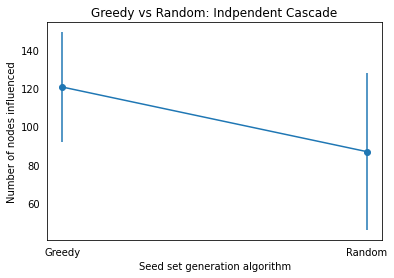

In [ ]:
print("Comparing result seed set of Greedy algorithm with aggregate of 5 random seed sets")
print("IC on seed set outputted by Greedy algorithm...")
print(f"Active Set({k}):", sorted(act_nodes))
gmean, gstd = ic.diffuse_mc(act_nodes, mc=100)
print(f"Number of nodes influenced (Mean+/-Std-dev.): {mean}+/-{std}")

print("IC on random seed sets...")
means = []
stds = []
for i in range(10):
    sampled_nodes = random.sample(G.nodes, k)
    print(f"Active Set({k}):", sorted(sampled_nodes))
    mean, std = ic.diffuse_mc(sampled_nodes, mc=100)
    print(f"Number of nodes influenced (Mean+/-Std-dev.): {mean}+/-{std}")
    means.append(mean); stds.append(std)
# finding means of the results from random
rmean = sum(means)/10; rstd = sum(stds)/10
means = [gmean, rmean]; stds = [gstd, rstd]
# plot errorbars
fig = plt.figure()
ax = fig.add_subplot(111)
ax.errorbar(["Greedy", "Random"], means, yerr=stds, label="Indpendent Cascade",fmt='-o')
plt.ylabel('Number of nodes influenced')
plt.xlabel('Seed set generation algorithm')
plt.title('Greedy vs Random: Indpendent Cascade')
plt.tick_params(bottom = False, left = False)
plt.show()

## Run Greedy over Linear Threshold

In [ ]:
# greedy on above graph using above IC object.
k = 15
p = random.uniform(0.05, 0.15)
lt = LinearThreshold(G)
act_nodes = celfpp(G, lt, k)

Initializing...


100%|██████████| 1000/1000 [15:10<00:00,  1.10it/s]


Current size of S: 0
Running Diffusion...
Current size of S: 1
Running Diffusion...
Current size of S: 0
Running Diffusion...
Current size of S: 1
Running Diffusion...
Current size of S: 1
Running Diffusion...
Current size of S: 1
Running Diffusion...
Current size of S: 1
Running Diffusion...
Current size of S: 1
Running Diffusion...
Current size of S: 1
Running Diffusion...
Current size of S: 1
Running Diffusion...
Current size of S: 1
Running Diffusion...
Current size of S: 1
Running Diffusion...
Current size of S: 1
Running Diffusion...
Current size of S: 1
Running Diffusion...
Current size of S: 1
Running Diffusion...
Current size of S: 1
Running Diffusion...
Current size of S: 1
Running Diffusion...
Current size of S: 1
Running Diffusion...
Current size of S: 1
Running Diffusion...
Current size of S: 1
Running Diffusion...
Current size of S: 1
Running Diffusion...
Current size of S: 1
Running Diffusion...
Current size of S: 1
Running Diffusion...
Current size of S: 1
Running Diffu

Comparing result seed set of Greedy algorithm with aggregate of 10 random seed sets
LT on seed set outputted by Greedy algorithm...
Active Set(15): [120, 171, 238, 242, 343, 377, 420, 596, 597, 640, 657, 681, 761, 953, 992]
Sampling Thresholds for Monte Carlo Simulations...
Running Monte Carlo simulations...
Number of nodes influenced (Mean+/-Std-dev.): 512.99+/-15.534578568893696
LT on random seed sets...
Active Set(15): [34, 41, 46, 176, 263, 272, 306, 335, 396, 409, 593, 633, 896, 906, 978]
Sampling Thresholds for Monte Carlo Simulations...
Running Monte Carlo simulations...
Number of nodes influenced (Mean+/-Std-dev.): 511.75+/-16.10218317590205
Active Set(15): [10, 95, 99, 179, 188, 197, 227, 403, 562, 578, 676, 788, 851, 853, 901]
Sampling Thresholds for Monte Carlo Simulations...
Running Monte Carlo simulations...
Number of nodes influenced (Mean+/-Std-dev.): 512.92+/-16.892219235703482
Active Set(15): [2, 44, 76, 277, 308, 365, 403, 490, 527, 529, 594, 702, 766, 918, 944]
Sampl

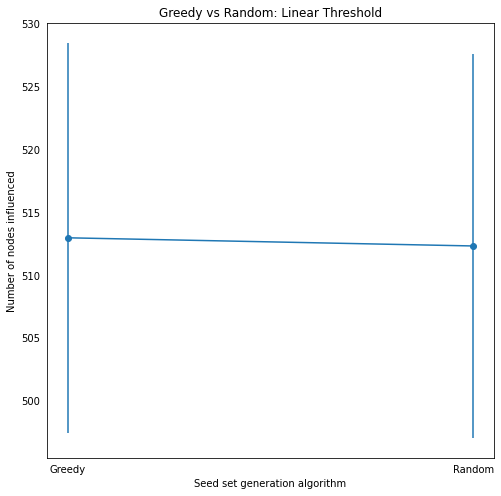

In [ ]:
print("Comparing result seed set of Greedy algorithm with aggregate of 10 random seed sets")
print("LT on seed set outputted by Greedy algorithm...")
print(f"Active Set({k}):", sorted(act_nodes))
gmean, gstd = lt.diffuse_mc(act_nodes, mc=100)
print(f"Number of nodes influenced (Mean+/-Std-dev.): {gmean}+/-{gstd}")

print("LT on random seed sets...")
means = []
stds = []
for i in range(10):
    sampled_nodes = random.sample(G.nodes, k)
    print(f"Active Set({k}):", sorted(sampled_nodes))
    mean, std = lt.diffuse_mc(sampled_nodes, mc=100)
    print(f"Number of nodes influenced (Mean+/-Std-dev.): {mean}+/-{std}")
    means.append(mean); stds.append(std)

# averaging over results of random
rmean = sum(means)/10; rstd = sum(stds)/10
means = [gmean, rmean]; stds = [gstd, rstd]
# plot errorbars
fig = plt.figure()
ax = fig.add_subplot(111)
ax.errorbar(["Greedy", "Random"], means, yerr=stds, label="Linear Threshold",fmt='-o')
plt.ylabel('Number of nodes influenced')
plt.xlabel('Seed set generation algorithm')
plt.title('Greedy vs Random: Linear Threshold')
plt.tick_params(bottom = False, left = False)
plt.show()

# References
1. https://github.com/Vinit-source/SNInfluenceMaximization